In [28]:
PFSSPEC_ROOT = '/home/dobos/project/pfs_spec_dnn'
PFSSPEC_DATA = '/scratch/ceph/dobos/data/pfsspec'
GRID_PATH = '/scratch/ceph/dobos/data/pfsspec/import/stellar/grid/bosz_5000_4/'

In [29]:
import os, sys, warnings

# Allow load project as module
sys.path.insert(0, PFSSPEC_ROOT)

# Set environment
os.environ['PFSSPEC_ROOT'] = PFSSPEC_ROOT
os.environ['PFSSPEC_DATA'] = PFSSPEC_DATA
os.environ['PYSYN_CDBS'] = os.path.join(os.environ['PFSSPEC_DATA'], 'cdbs')

# Filter warnings
warnings.filterwarnings("ignore")

In [30]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [31]:
import os
import getpass
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

from scipy.optimize import curve_fit
from scipy import ndimage
from scipy.ndimage.filters import maximum_filter1d
from scipy.interpolate import Rbf, interp1d, interpn

from pfsspec.physics import Physics

from pfsspec.stellarmod.alexcontinuummodel import AlexContinuumModel, AlexContinuumModelTrace

# Load grid

In [32]:
from pfsspec.data.arraygrid import ArrayGrid
from pfsspec.stellarmod.modelgrid import ModelGrid
from pfsspec.stellarmod.bosz import Bosz

In [33]:
fn = os.path.join(os.environ['PFSSPEC_DATA'], GRID_PATH, 'spectra.h5')

In [34]:
grid = ModelGrid(Bosz(), ArrayGrid)
grid.preload_arrays = False
grid.load(fn, format='h5')

In [35]:
for k in grid.grid.axes:
    print(k, grid.grid.axes[k].values)

Fe_H [-2.5  -2.25 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25
  0.5   0.75]
T_eff [ 3500.  3750.  4000.  4250.  4500.  4750.  5000.  5250.  5500.  5750.
  6000.  6250.  6500.  6750.  7000.  7250.  7500.  7750.  8000.  8250.
  8500.  8750.  9000.  9250.  9500.  9750. 10000. 10250. 10500. 10750.
 11000. 11250. 11500. 11750. 12000. 12500. 13000. 13500. 14000. 14500.
 15000. 15500. 16000. 16500. 17000. 17500. 18000. 18500. 19000. 19500.
 20000. 21000. 22000. 23000. 24000. 25000. 26000. 27000. 28000. 29000.
 30000. 31000. 32000. 33000. 34000. 35000.]
log_g [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
C_M [-0.75 -0.5  -0.25  0.    0.25  0.5 ]
O_M [-0.25  0.    0.25  0.5 ]


In [36]:
for k in grid.grid.values:
    print(k, grid.grid.value_shapes[k])

flux (21691,)
cont (21691,)
params None


# Pick a spectrum and fit with model

In [67]:
Fe_H = -2
T_eff = 3750
log_g = 1
O_M = 0
C_M = 0

In [68]:
idx = grid.array_grid.get_nearest_index(Fe_H=Fe_H, T_eff=T_eff, log_g=log_g, O_M=O_M, C_M=C_M)
idx

(2, 1, 2, 3, 1)

In [69]:
#idx = (0, 12, 10, 3, 1)

In [70]:
spec = grid.get_model_at(idx)

In [71]:
spec.Fe_H, spec.T_eff, spec.log_g, spec.O_M, spec.C_M

(-2.0, 3750.0, 1.0, 0.0, 0.0)

In [72]:
trace = AlexContinuumModelTrace()
model = AlexContinuumModel(trace=trace)
model.init_wave(spec.wave)

params = model.fit(spec)
params.shape

(36,)

In [73]:
trace.blended_p0, trace.blended_params

({0: array([ 0.82513473, 25.27235734,  8.03375969,  0.5       ,  0.5       ]),
  1: array([0.12975847, 2.50018212, 8.37444966, 0.5       , 0.5       ]),
  2: array([1.46074342e-03, 5.03646940e+00, 9.05826923e+00, 5.00000000e-01,
         5.00000000e-01])},
 {0: array([ 1.02937862, 21.25144869,  8.03201407,  0.78480801,  1.        ]),
  1: array([0.13279079, 4.04498038, 8.35426286, 0.22977273, 0.37264069]),
  2: array([2.78409118e-03, 6.77926215e+00, 9.01338094e+00, 2.85851937e-01,
         9.97232349e-01])})

Text(0.5, 1.0, 'Original spectrum and theoretical continuum')

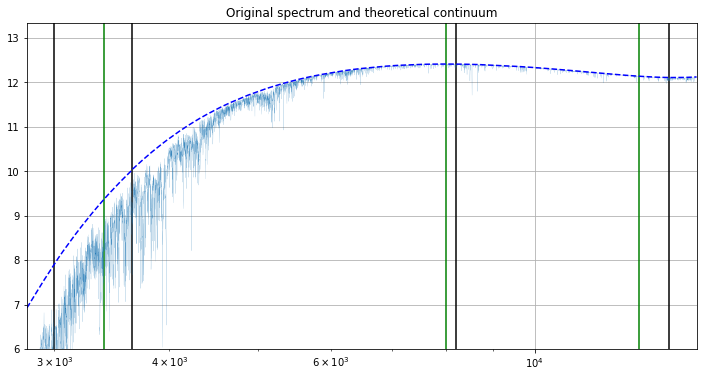

In [74]:
plt.figure(figsize=(12, 6))

for w in model.limit_wave:
    plt.axvline(w, c='k')

for w in model.blended_bounds:
    plt.axvline(w, c='green')

plt.plot(spec.wave, np.log(spec.flux), lw=0.1)
plt.plot(spec.wave, np.log(spec.cont), 'b--')

plt.xlim(2800, 15000)
plt.ylim(6, None)
plt.grid(True)

plt.xscale('log')
plt.title('Original spectrum and theoretical continuum')

Text(0.5, 1.0, 'Spectrum normalized by theoretical continuum')

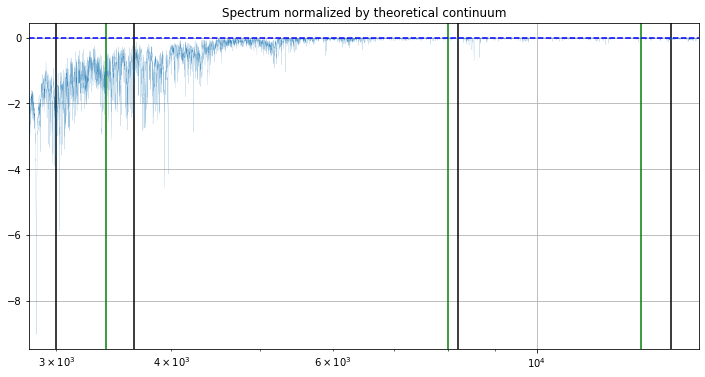

In [75]:
plt.figure(figsize=(12, 6))

for w in model.limit_wave:
    plt.axvline(w, c='k')

for w in model.blended_bounds:
    plt.axvline(w, c='green')

plt.plot(spec.wave, np.log(spec.flux) - np.log(spec.cont), lw=0.1)
plt.axhline(0, c='b', ls='--')

plt.xlim(2800, 15000)
# plt.ylim(6, None)
plt.grid(True)

plt.xscale('log')
plt.title('Spectrum normalized by theoretical continuum')

In [76]:
wave = model.wave
cont = model.eval_continuum_all(params)

Text(0.5, 1.0, 'Spectrum and fitted theoretical continuum')

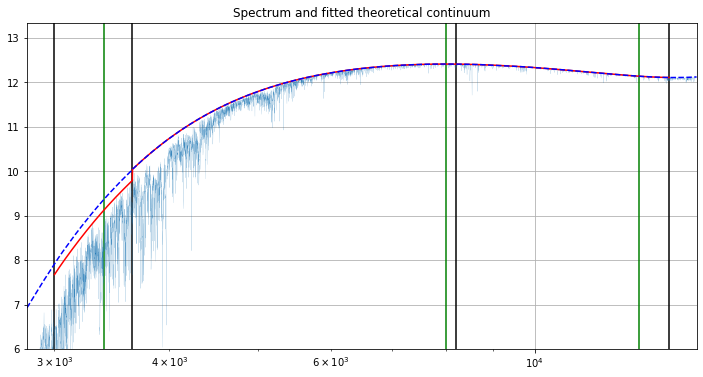

In [77]:
plt.figure(figsize=(12, 6))

for w in model.limit_wave:
    plt.axvline(w, c='k')

for w in model.blended_bounds:
    plt.axvline(w, c='green')

plt.plot(spec.wave, np.log(spec.flux), lw=0.1)
plt.plot(wave, cont, c='r')
plt.plot(spec.wave, np.log(spec.cont), 'b--')

plt.xlim(2800, 15000)
plt.ylim(6, None)
plt.grid(True)

plt.xscale('log')
plt.title('Spectrum and fitted theoretical continuum')

In [78]:
wave = model.wave
blend = model.eval_blended_all(params)

Text(0.5, 1.0, 'Upper envelope fit')

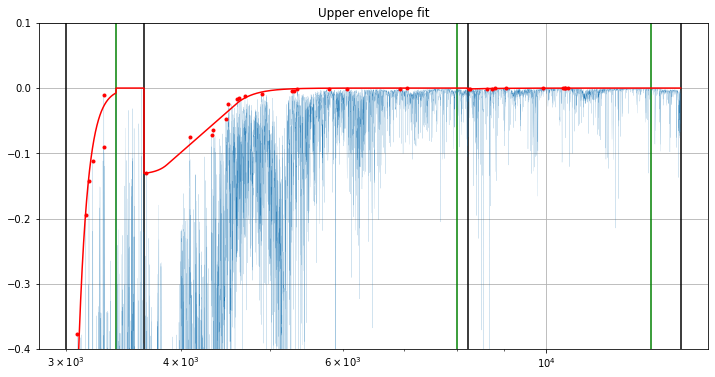

In [79]:
plt.figure(figsize=(12, 6))

for w in model.limit_wave:
    plt.axvline(w, c='k')

for w in model.blended_bounds:
    plt.axvline(w, c='green')

plt.plot(spec.wave[model.wave_mask], np.log(spec.flux[model.wave_mask]) - cont, lw=0.1)
plt.plot(wave, blend, c='r')

for k, v in trace.blended_control_points.items():
    (x, y) = v
    plt.plot(np.exp(x), y, 'r.')

plt.xlim(2800, 15000)
plt.ylim(-0.4, 0.1)
plt.grid(True)

plt.xscale('log')

plt.title('Upper envelope fit')

In [50]:
wave, cont = model.eval(params)

Text(0.5, 1.0, 'Upper envelope fit')

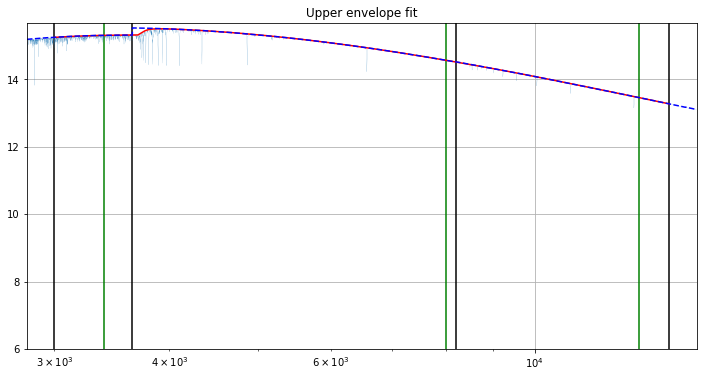

In [51]:
plt.figure(figsize=(12, 6))

for w in model.limit_wave:
    plt.axvline(w, c='k')

for w in model.blended_bounds:
    plt.axvline(w, c='green')

plt.plot(spec.wave, np.log(spec.flux), lw=0.1)
plt.plot(wave, cont, c='r')
plt.plot(spec.wave, np.log(spec.cont), 'b--')

plt.xlim(2800, 15000)
plt.ylim(6, None)
plt.grid(True)

plt.xscale('log')

plt.title('Upper envelope fit')

Text(0.5, 1.0, 'Normalized spectrum')

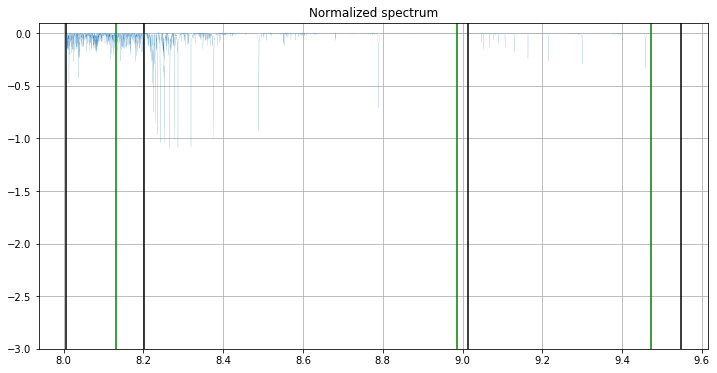

In [52]:
plt.figure(figsize=(12, 6))

for w in model.limit_wave:
    plt.axvline(np.log(w), c='k')

for w in model.blended_bounds:
    plt.axvline(np.log(w), c='green')

#plt.plot(np.log(spec.wave), np.log(spec.flux / spec.cont))
plt.plot(model.log_wave, np.log(spec.flux[model.wave_mask]) - cont, lw=0.1)

plt.xlim(np.log(2800), np.log(15000))
plt.ylim(-3, 0.1)
plt.grid(True)

plt.title('Normalized spectrum')

Text(0.5, 1.0, 'Normalized spectrum')

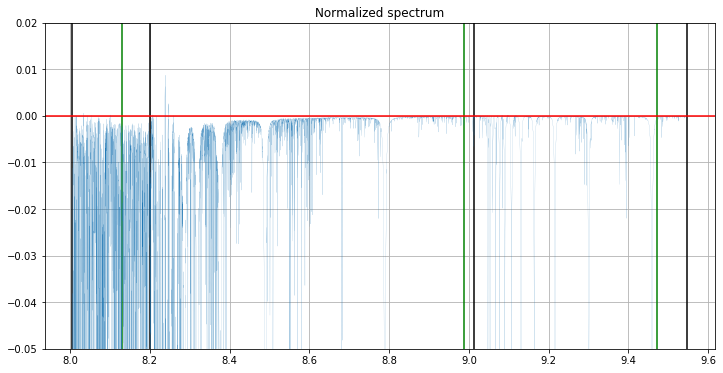

In [53]:
plt.figure(figsize=(12, 6))

for w in model.limit_wave:
    plt.axvline(np.log(w), c='k')

for w in model.blended_bounds:
    plt.axvline(np.log(w), c='green')

#plt.plot(np.log(spec.wave), np.log(spec.flux / spec.cont))
plt.plot(model.log_wave, np.log(spec.flux[model.wave_mask]) - cont, lw=0.1)
plt.axhline(0, c='r')

plt.xlim(np.log(2800), np.log(15000))
plt.ylim(-0.05, 0.02)
plt.grid(True)

plt.title('Normalized spectrum')